In [ ]:
# %%
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')
sys.path.append("../../neuroformer/neuroformer")


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, print_full


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

In [ ]:
DATASET = 'NaturalMovie'
DATASET = 'NaturalStim'

In [ ]:
data_dir = "../data/NaturalMovie/"
data_dir = "../data/NaturalStim/"

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/1jgYBERZpXdbAP-E5xcSAHsWSa95Z9IFe?usp=sharing"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")



In [ ]:
# load config files
import yaml

base_path = f"../configs/{DATASET}"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

# with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
#     dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
# dconf = OmegaConf.create(dconf)

In [ ]:
frame_window = 0.05
window = 0.05
window_prev = 0.2
window_behavior = window
dt = 0.005
dt_frames = 0.05
dt_vars = 0.05
intervals = None
n_frames = frame_window // dt_frames


In [ ]:
## choose modalities ##

# behavior
visual_stim = True


In [ ]:
from neuroformer.SpikeVidUtils import trial_df_real, make_intervals
from neuroformer.prepare_data import load_natmovie_real

response_path = ".././data/NaturalStim/20-NatureMovie_part1-A_spikes(1).mat"
stimulus_path = ".././data/NaturalMovie/stimulus/docuMovie.pt"
df, stimulus = load_natmovie_real(response_path, stimulus_path, dt_frames)


df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']



In [ ]:
tif_path = "/data5/antonis/neuroformer/data/Combo3_V1AL/stimuli/Combined Stimuli 3-Movie2.tif"
# load tif
import tifffile
tif = tifffile.imread(tif_path)

In [ ]:
combo3_stim_pth = "../data/Combo3_V1AL/Combo3_V1AL_stimulus.pt"
combo3_stim = torch.load(combo3_stim_pth)
combo3_stim2 = combo3_stim[1]
print(combo3_stim.shape)

In [ ]:
from torchvision import transforms
# im_indexes = range(0, 5)
n_images = 50
im_indexes = np.random.choice(range(len(combo3_stim2)), n_images)
# images = combo3_stim2[im_indexes]
images = torch.tensor(tif[im_indexes]).unsqueeze(1)
pil_images = [transforms.ToPILImage(mode='L')(image) for image in images]

In [ ]:
plt.imshow(images[0].permute(1, 2, 0).repeat(1, 1, 3), cmap='gray')

image_rgb = images[0].repeat(3, 1, 1)
img = transforms.ToPILImage(mode='RGB')(image_rgb)

# # if want custom image, use this

# im_path = "data/test_images/1_mouse.jpg"
# im = Image.open(im_path)
# pil_images = [im]

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from PIL import Image


weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
transform = weights.transforms()
# C, H, W
im_transform = transforms.Compose([
    transforms.ToPILImage(mode='RGB'),
    transforms.ToTensor(),
])

# image_inputs = [transform(transforms.ToPILImage(mode='RGB')(image.repeat(3,1,1))) for image in images]
image_inputs = [transform(im_transform(image.repeat(3, 1, 1))) for image in images]
# image_inputs = [transform(transforms.ToTensor()(im))]

model = fasterrcnn_resnet50_fpn_v2(weights=weights, progress=False)
model = model.eval()

outputs = model(image_inputs)

for n, output in enumerate(outputs):
    print(f"{n}: {output['labels']}")

In [ ]:
# for idx, image in enumerate(image_inputs):
#     plt.imshow(image.permute(1, 2, 0))
#     plt.title(f"Image {idx}")
#     plt.figure()

In [ ]:
mouse_label = 65
for n, output in enumerate(outputs):
    labels = output['labels']
    # find if mouse_label in labels
    if mouse_label in labels:
        # get matching inde//x
        idx = np.where(labels == mouse_label)[0][0]
        # get probabilities
        probs = output['scores'][idx]
        print(f"Mouse label {mouse_label} found in image {n} with prob {probs}.")
    else:
        print(f"Mouse label {mouse_label} not found in image {n}.")

In [33]:
pics_without_boxes[0].shape

torch.Size([1, 175, 319])

In [34]:
pics_with_boxes[0].shape

torch.Size([3, 175, 319])

/tmp/ipykernel_1603778/998393921.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 10))


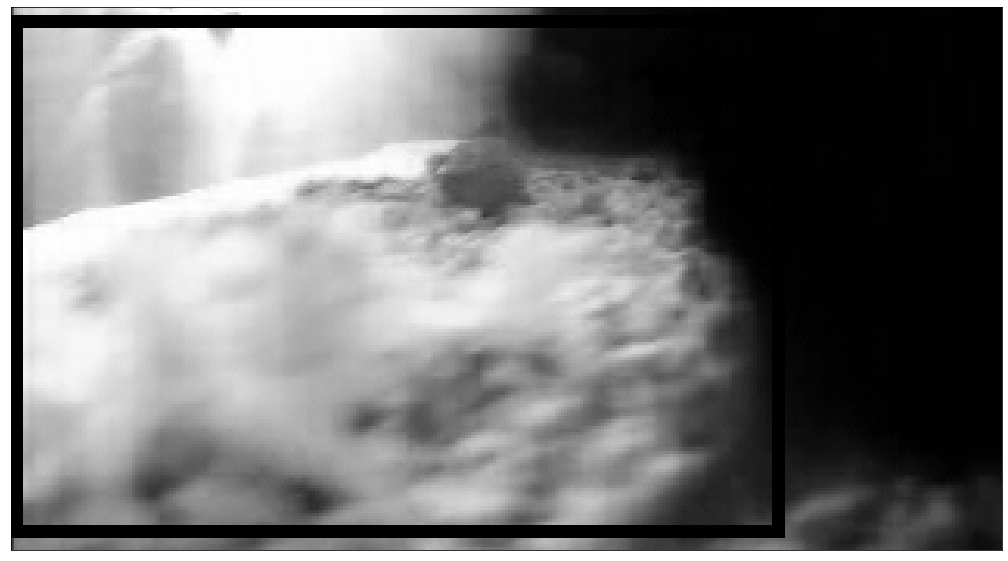

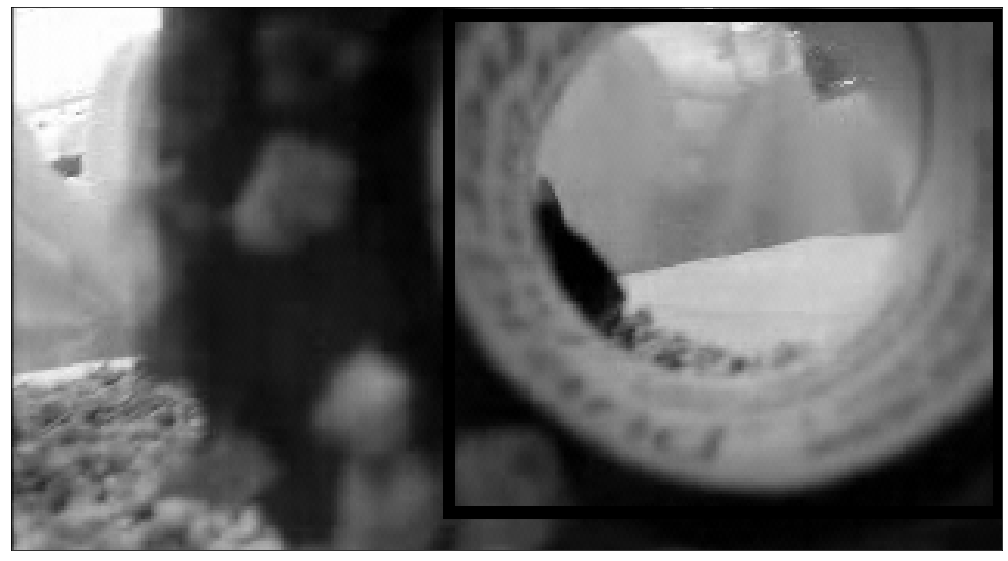

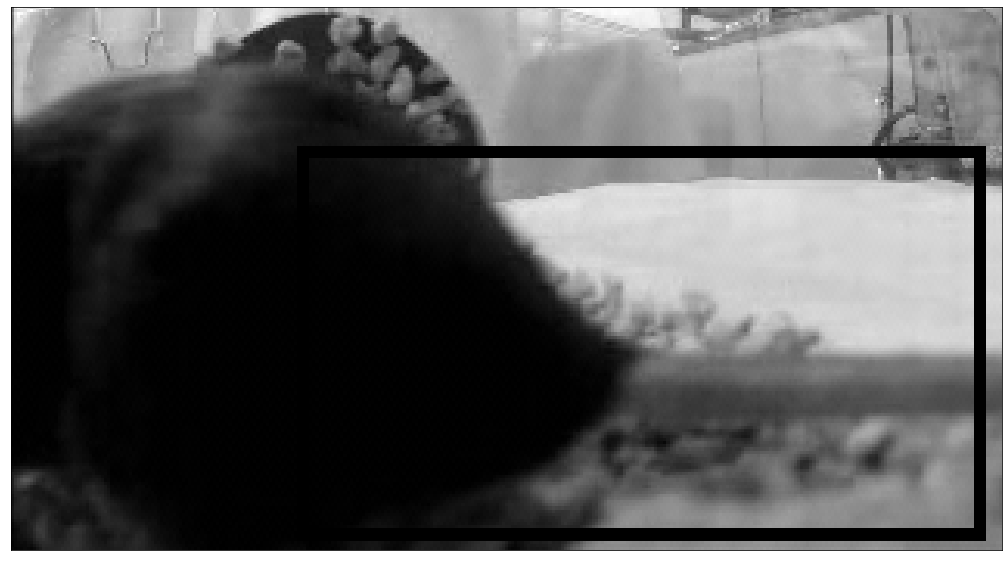

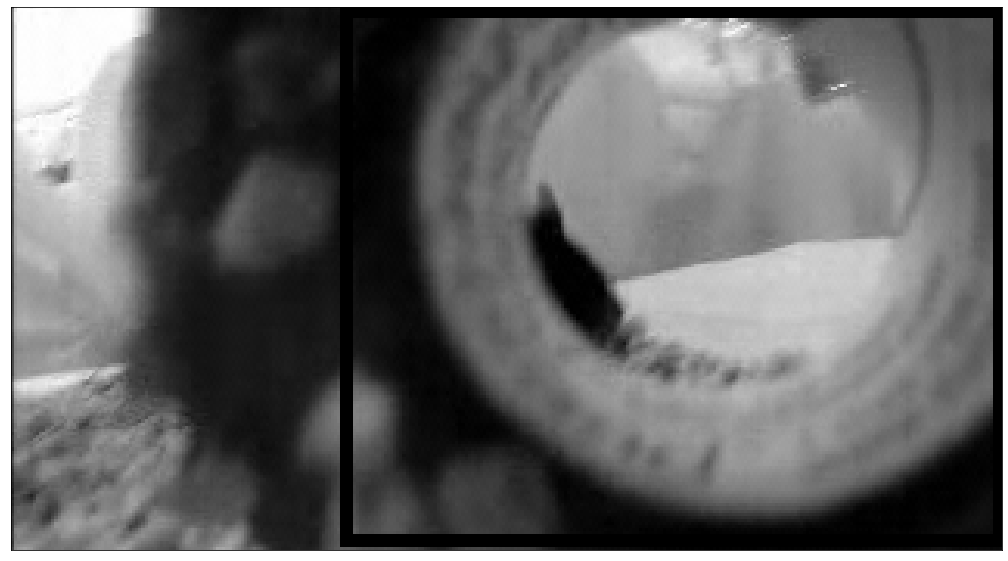

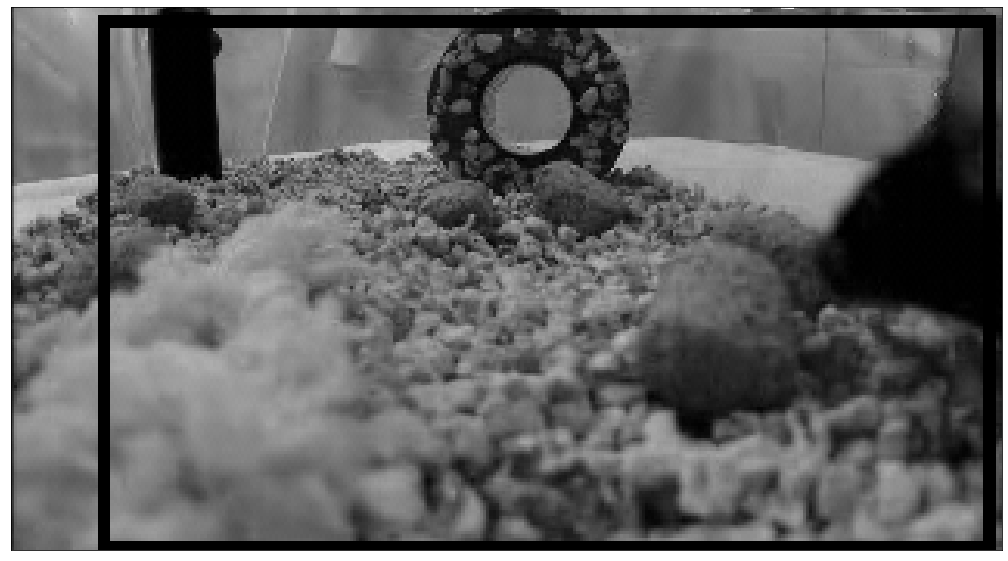

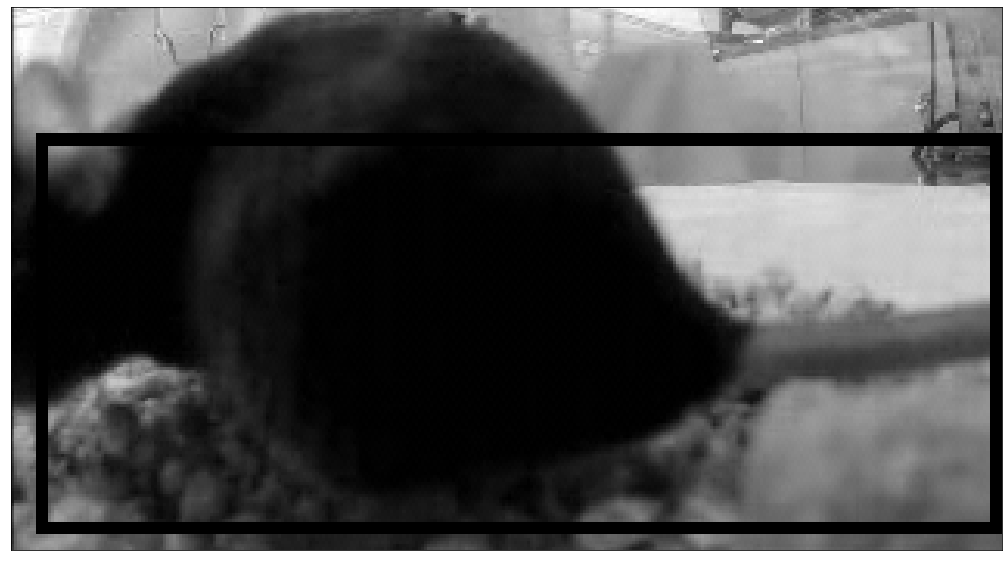

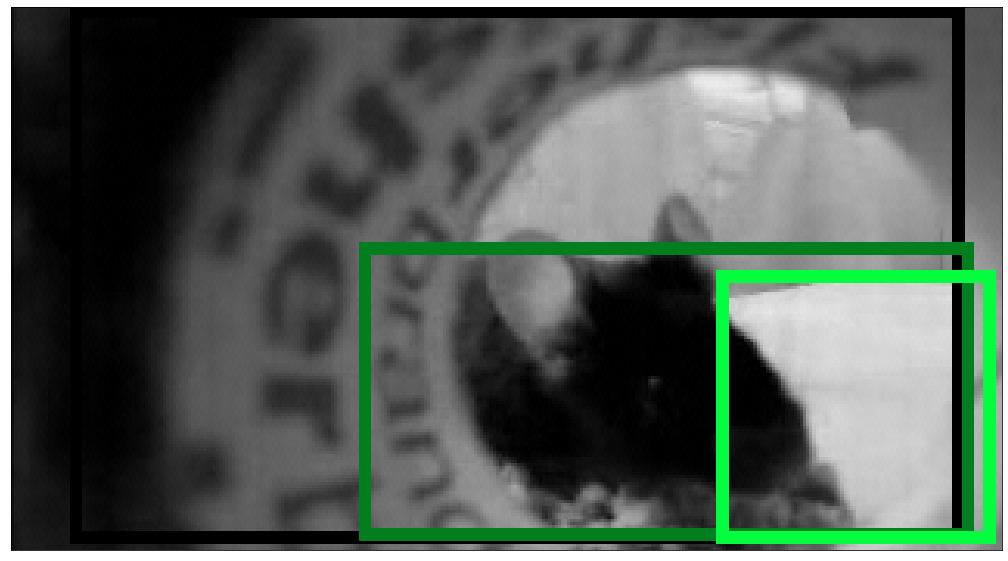

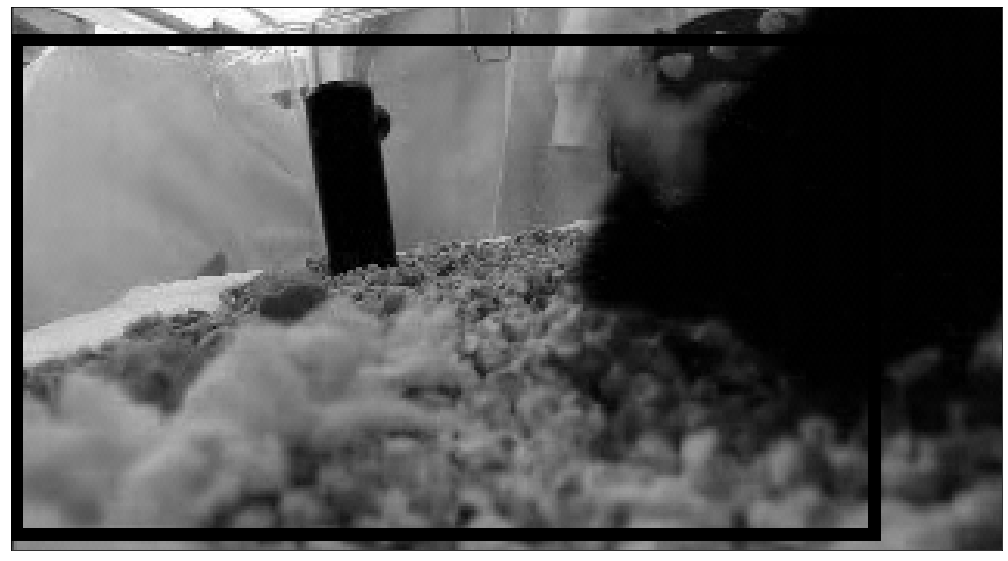

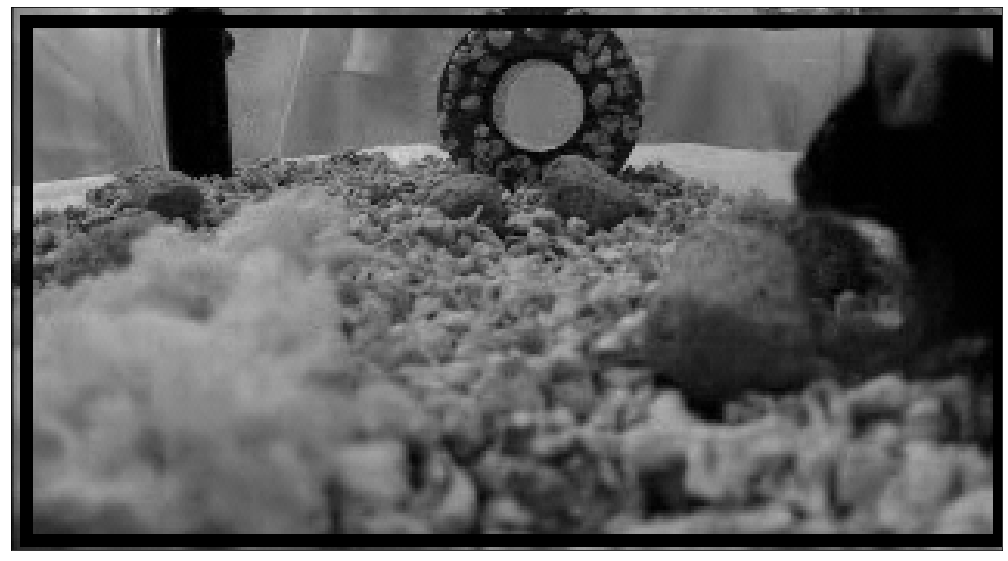

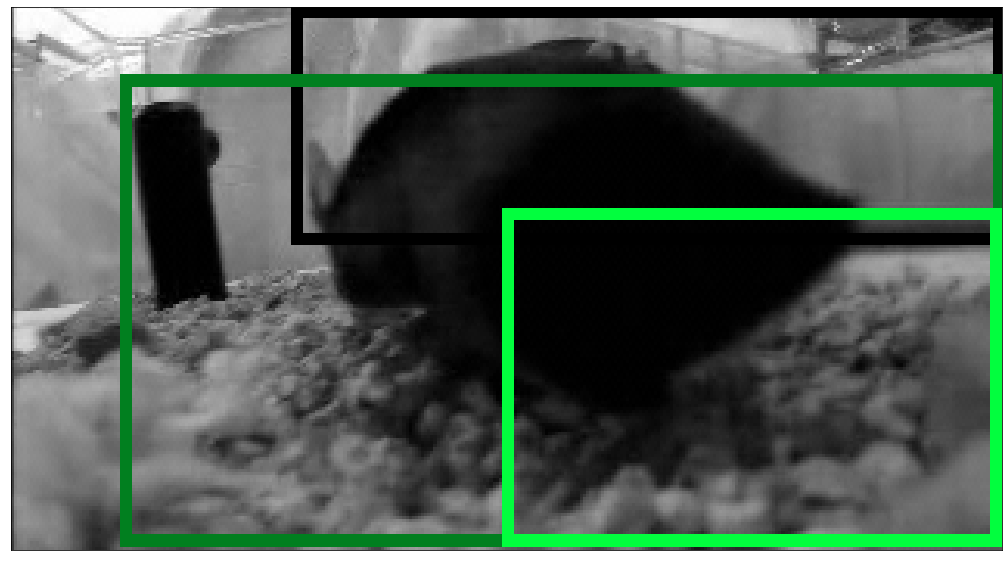

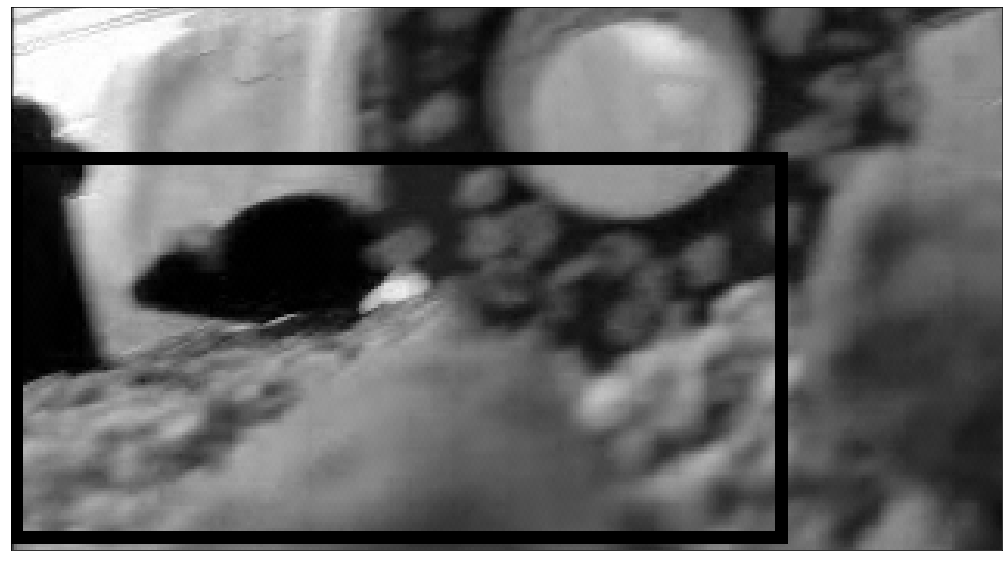

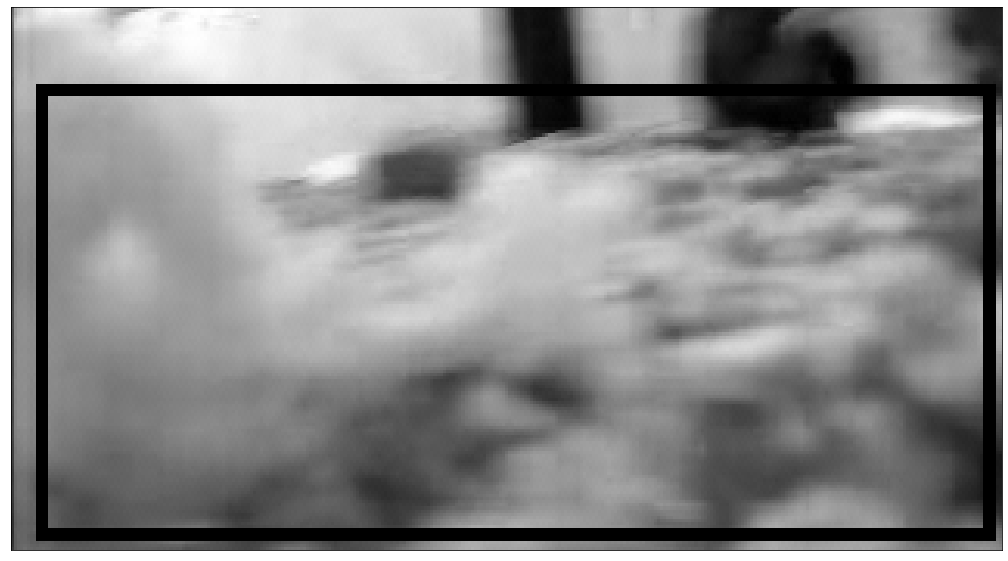

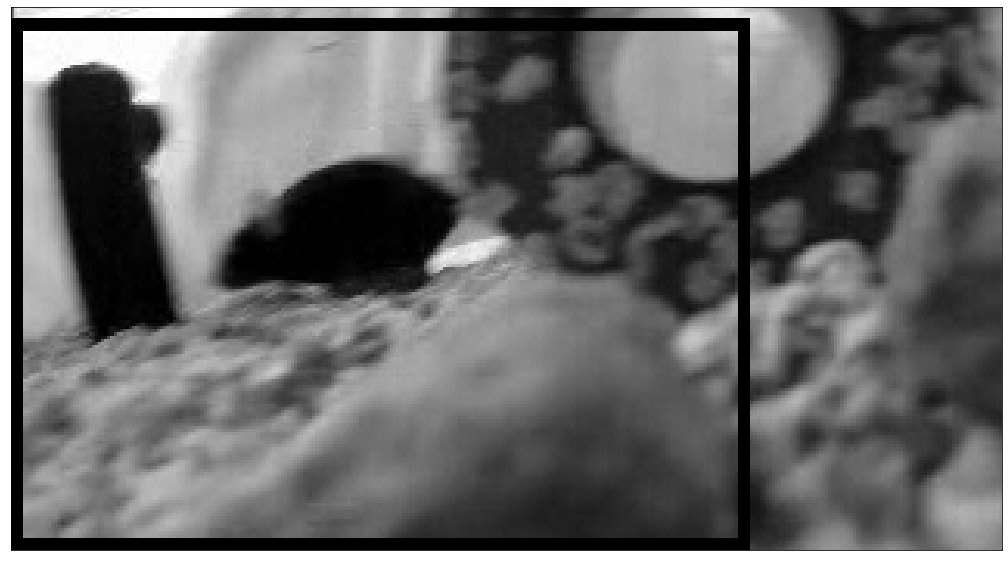

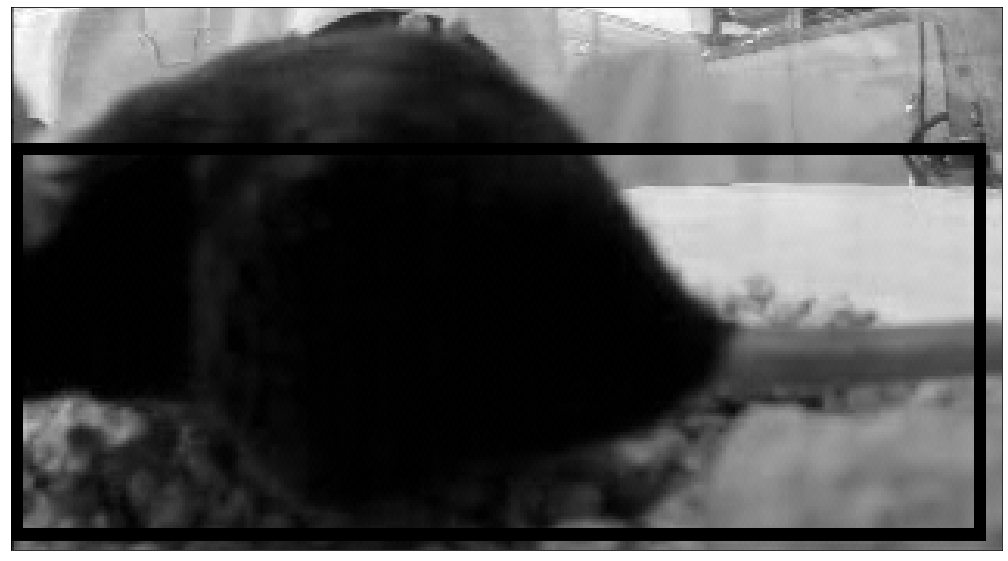

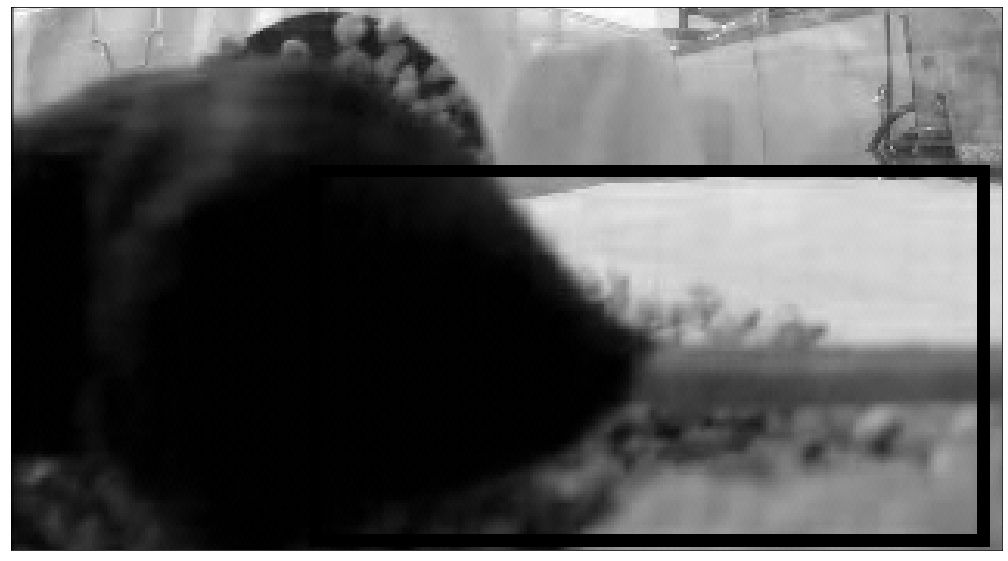

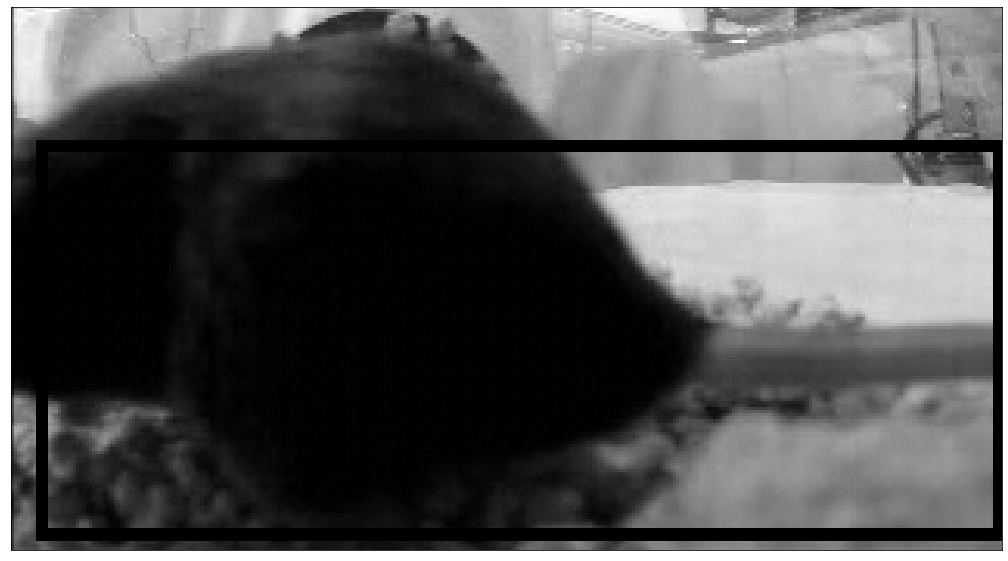

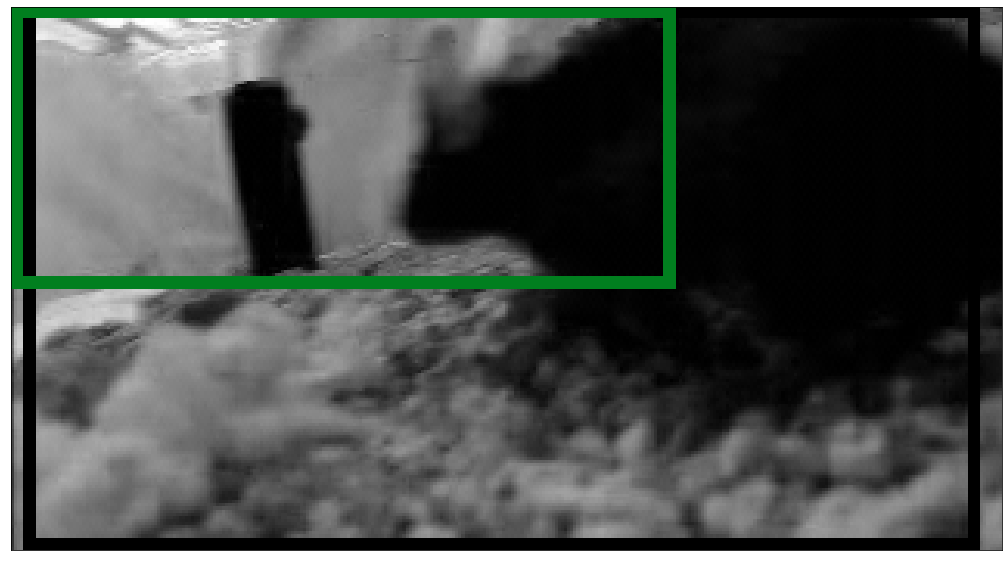

In [45]:
mouse_idx = range(139, 200)
from torchvision.utils import draw_bounding_boxes

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 10))
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach() if img.requires_grad else img
            img = img.permute(1, 2, 0)
        else:
            img = transforms.ToPILImage(mode='RGB')(img)
        img = np.asarray(img)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        # set axis title:

def get_class_boxes(output, class_idx=65, score_threshold=0.1):
    labels = output['labels']
    # find if mouse_label in labels
    idx = np.where((labels == class_idx) & (output['scores'] > score_threshold))[0]
    if len(idx) > 0:
        # get matching inde//x
        probs = output['scores'][idx]
        # get only boxes where prob > score_threshold
        output['boxes'][idx]
        boxes = output['boxes'][idx]
        if len(boxes.shape) == 1:
            boxes = boxes.unsqueeze(0)
        return boxes, probs
    else:
        return None, None

pics_with_boxes = []
pics_without_boxes = []
for im, output in zip(pil_images, outputs):
    im_array = torch.tensor(np.asarray(im))
    if len(im_array.shape) > 2:
        im_array = im_array.permute(2, 0, 1)
    elif len(im_array.shape) == 2:
        im_array = im_array.unsqueeze(0)
    bboxes_mouse, probs_mouse = get_class_boxes(output, class_idx=65)
    if bboxes_mouse is not None:
        bboxes = draw_bounding_boxes(im_array, boxes=bboxes_mouse, width=4)
        # bboxes = draw_bounding_boxes(im_array, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
        pics_with_boxes.append(bboxes)
    else:
        pics_without_boxes.append(im_array)

for pic in pics_with_boxes:
    show([pic])

PIC WITHOUT BOXES


/tmp/ipykernel_1603778/998393921.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 10))


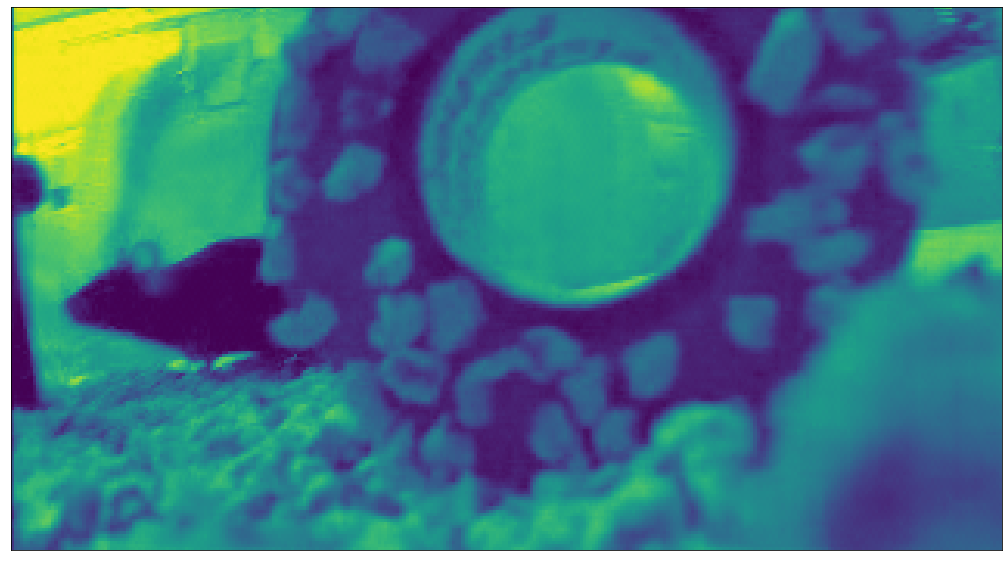

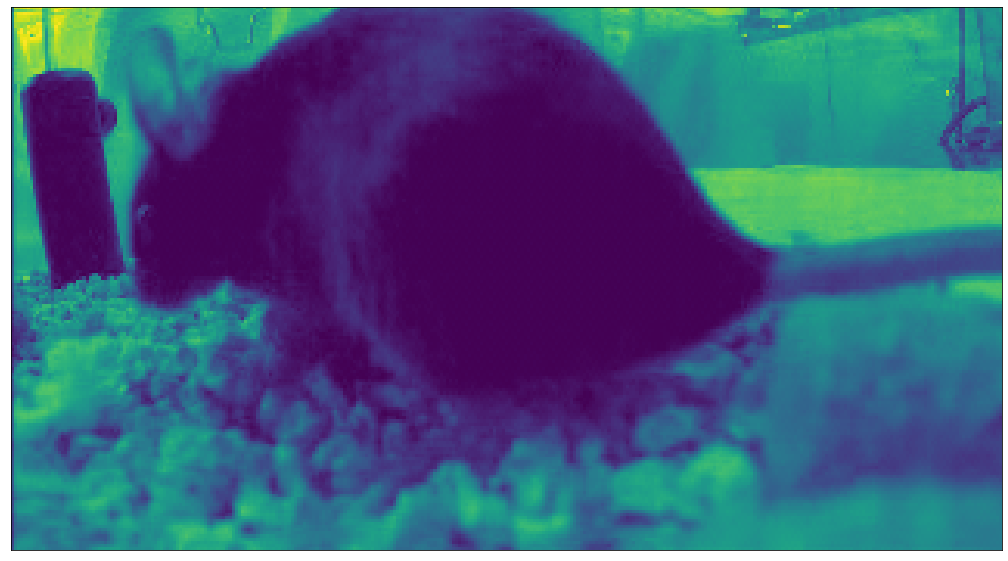

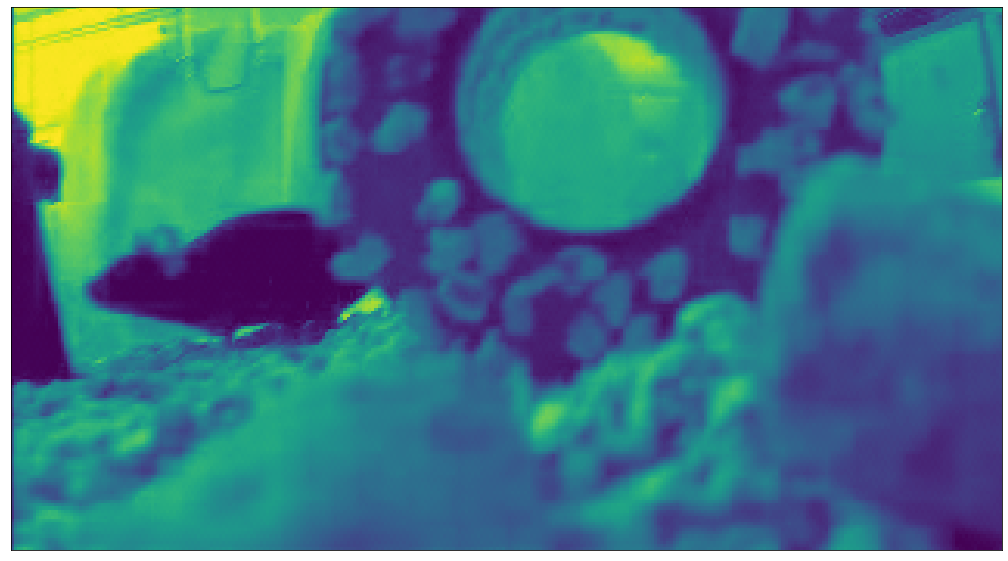

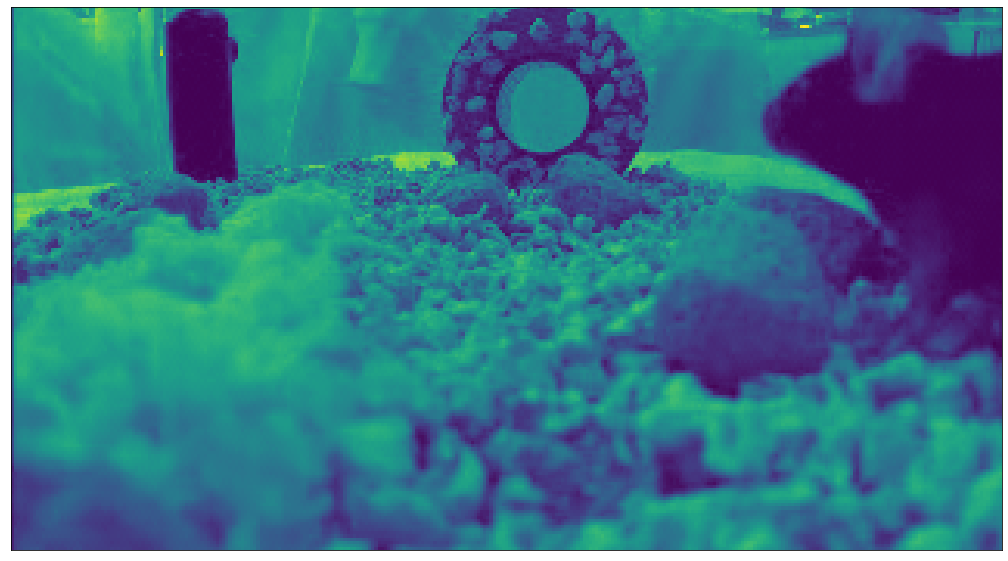

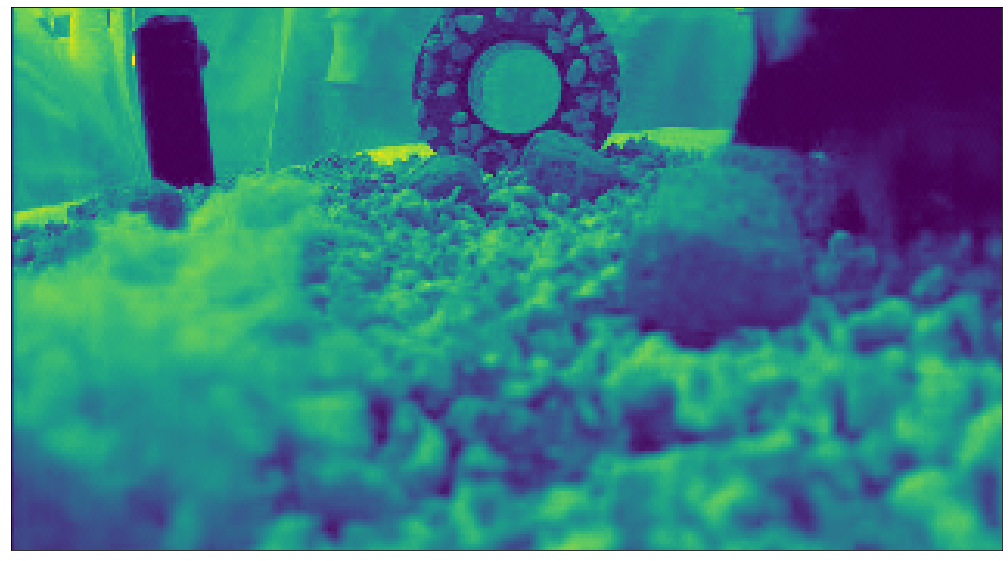

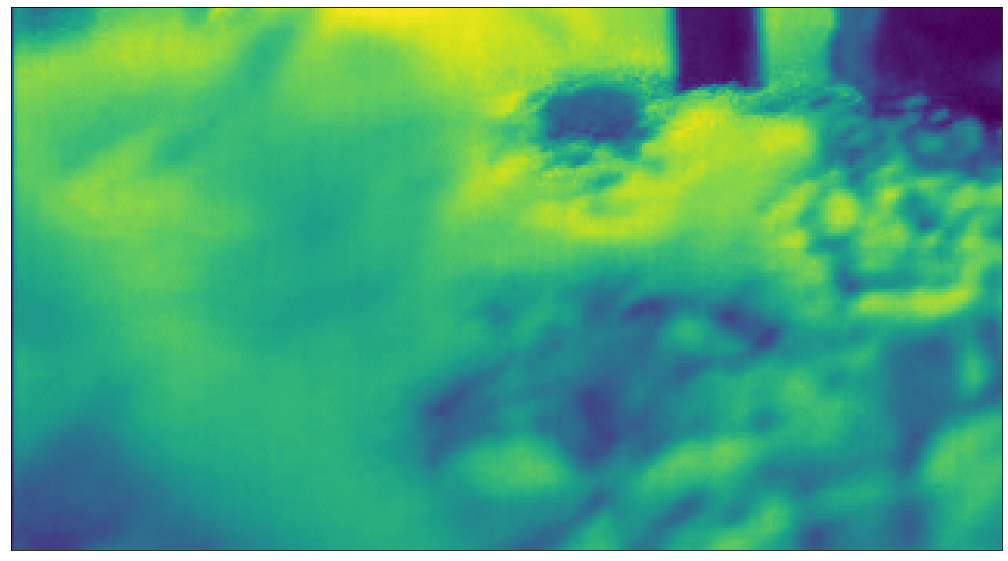

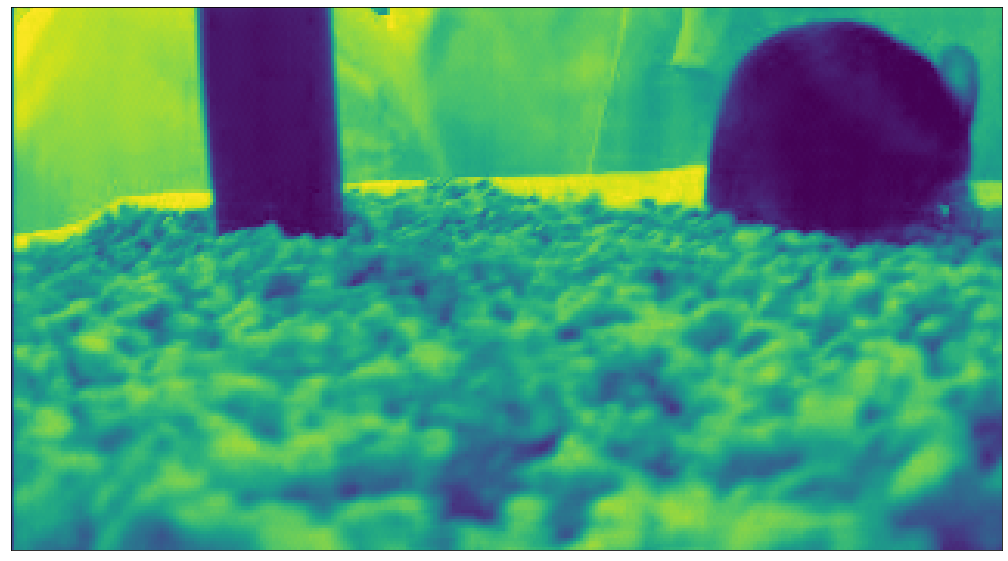

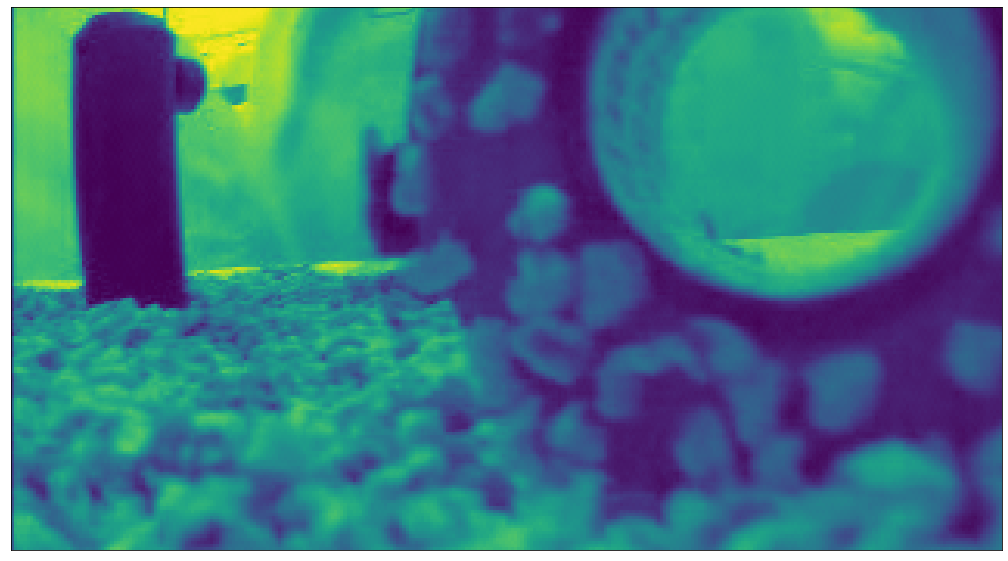

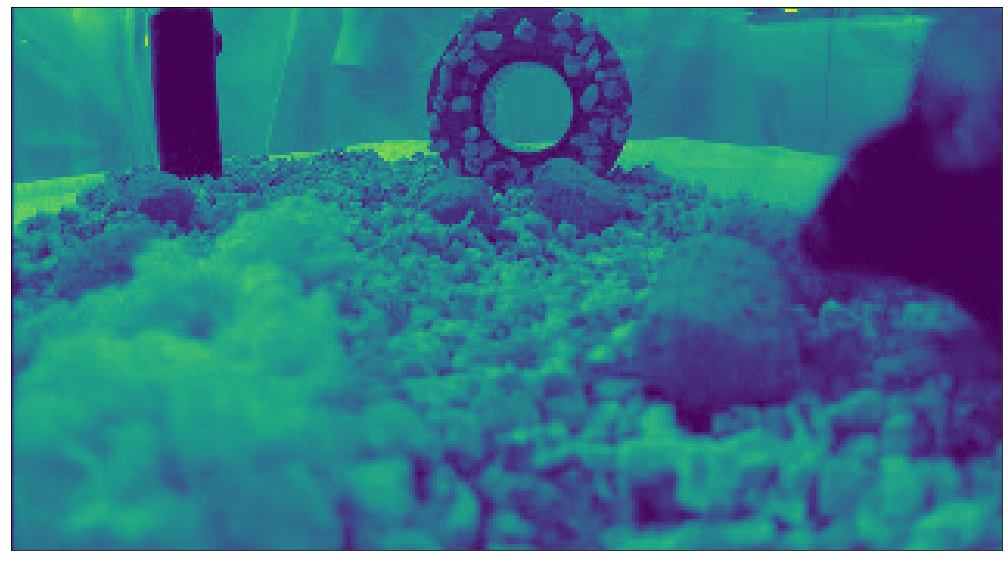

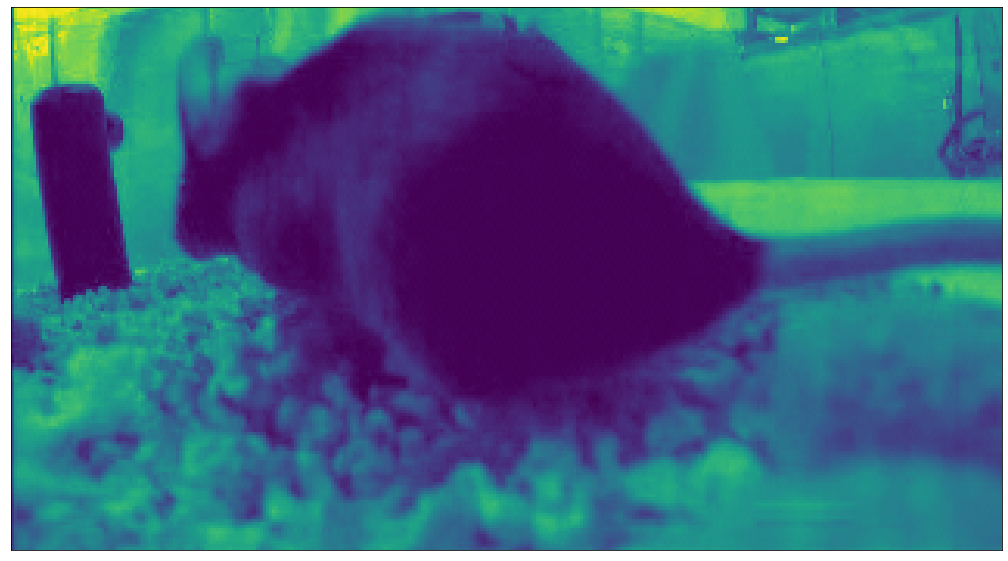

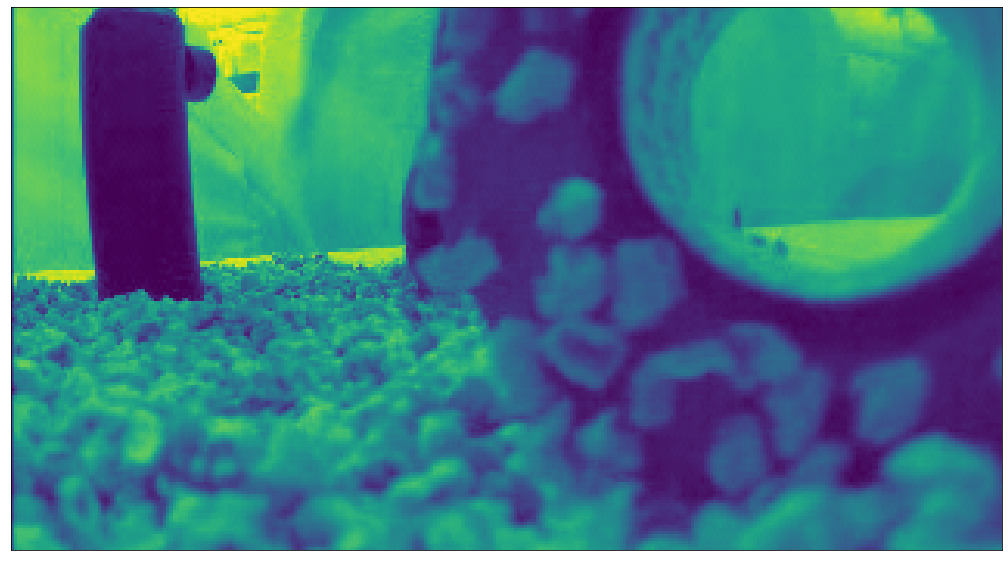

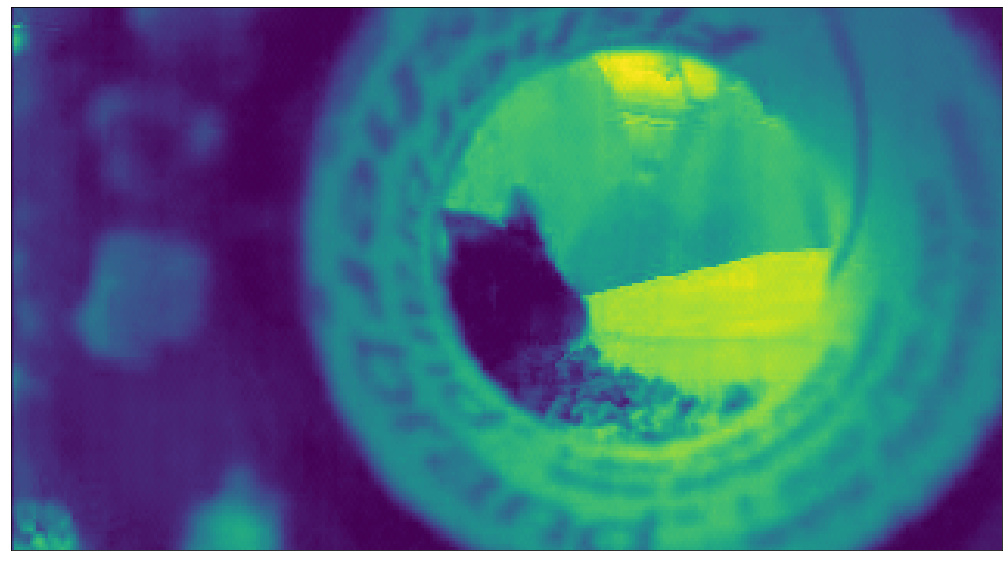

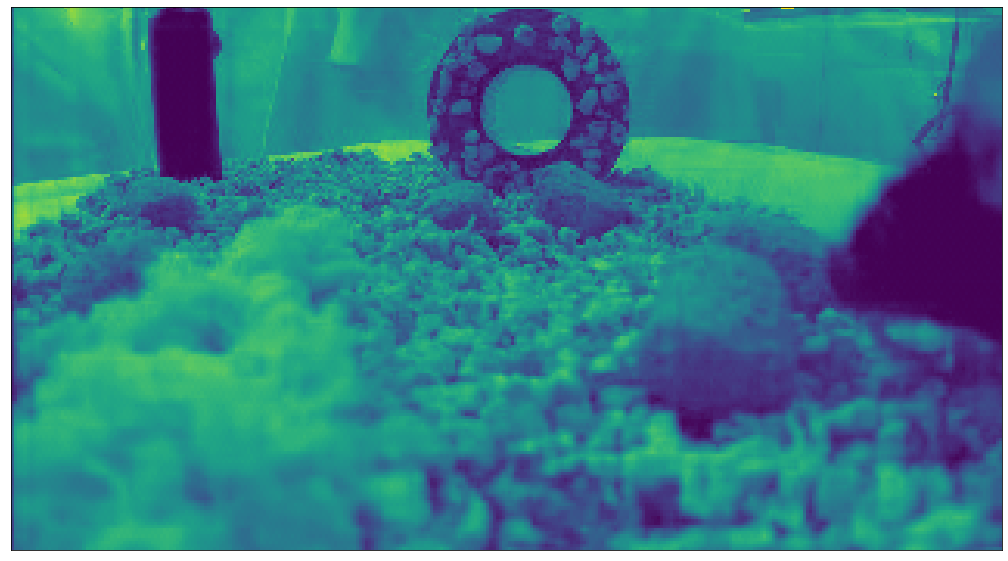

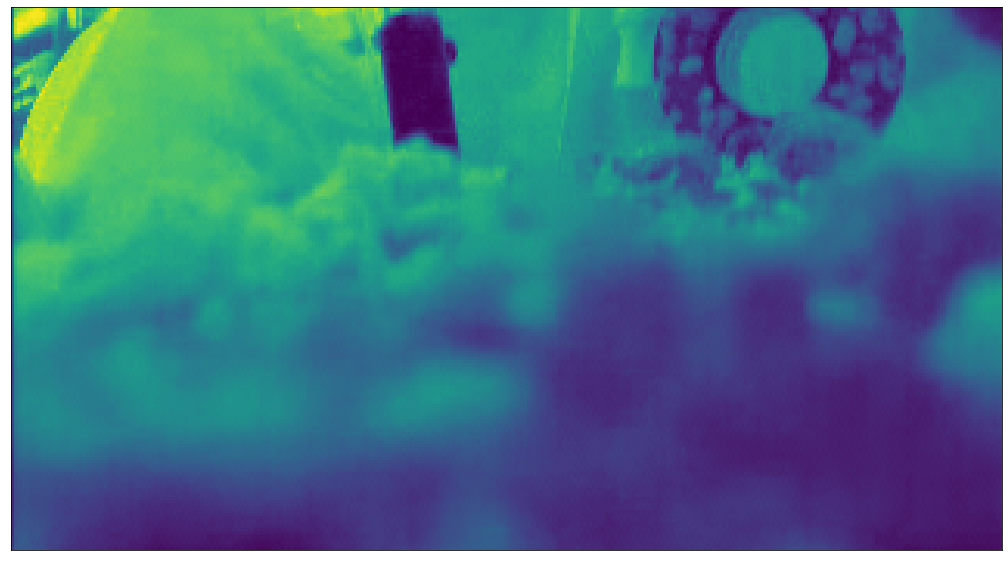

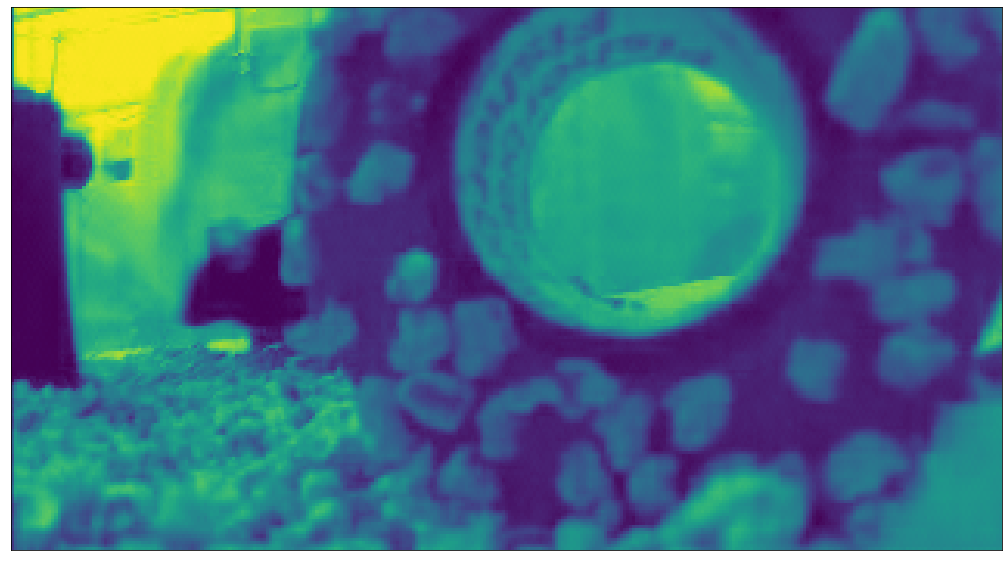

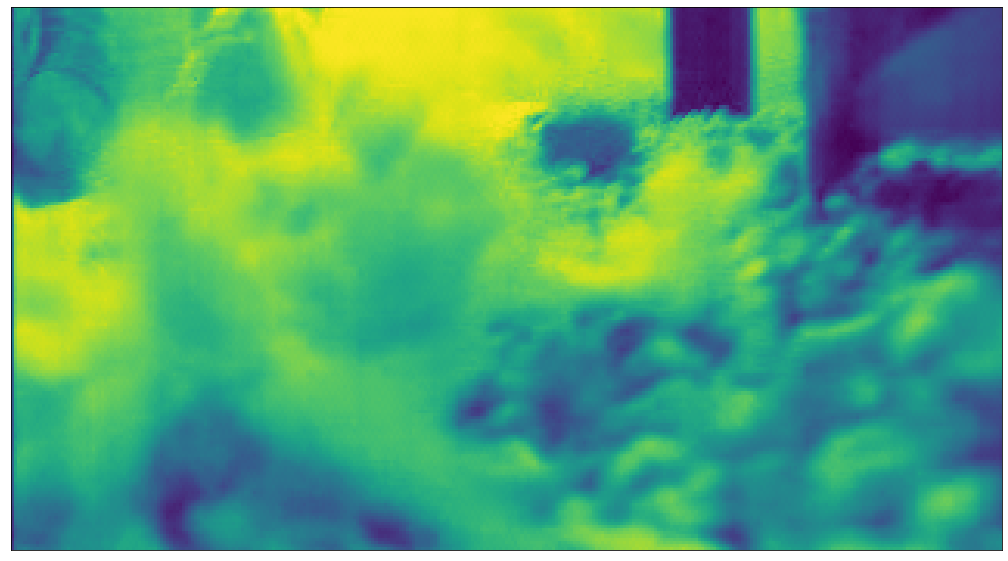

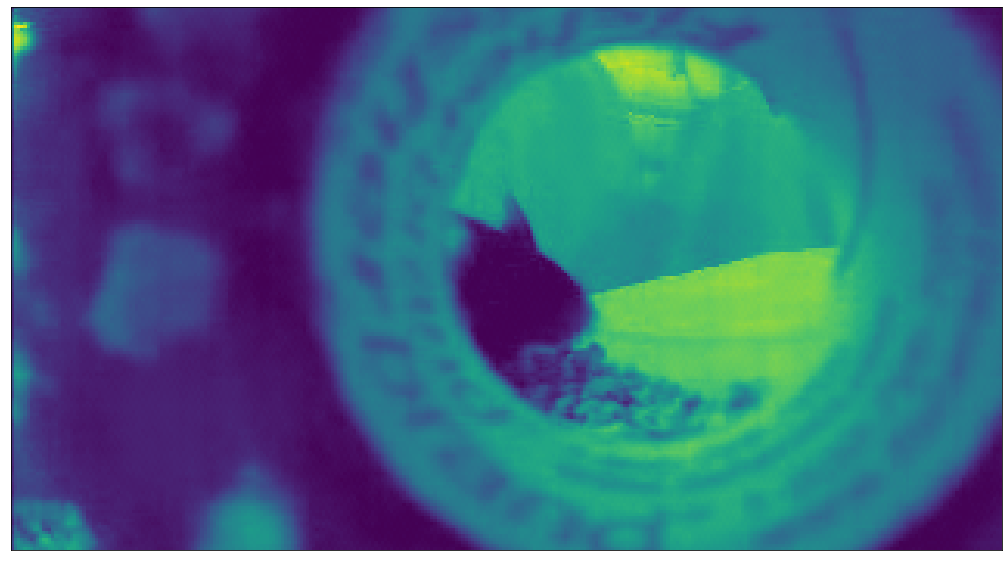

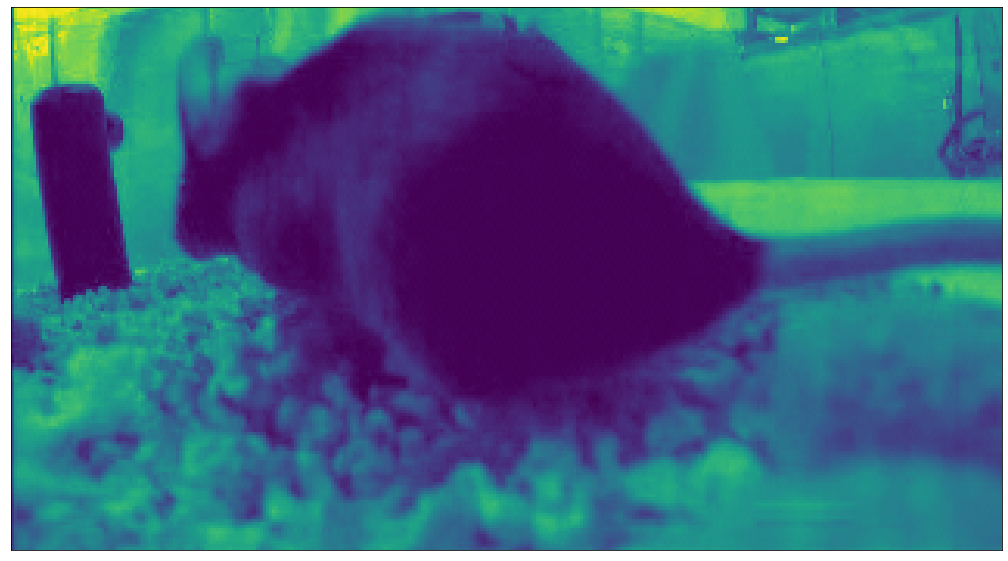

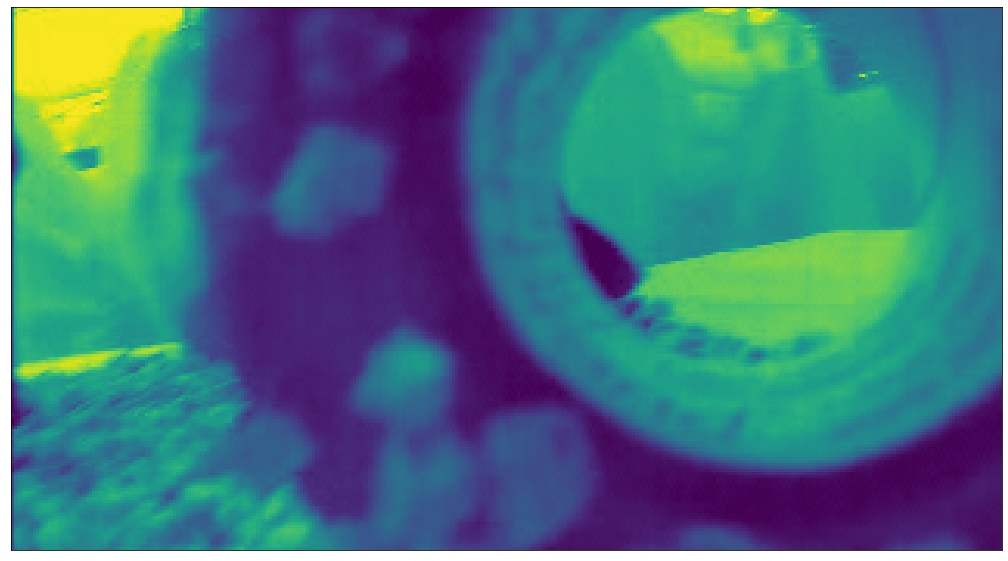

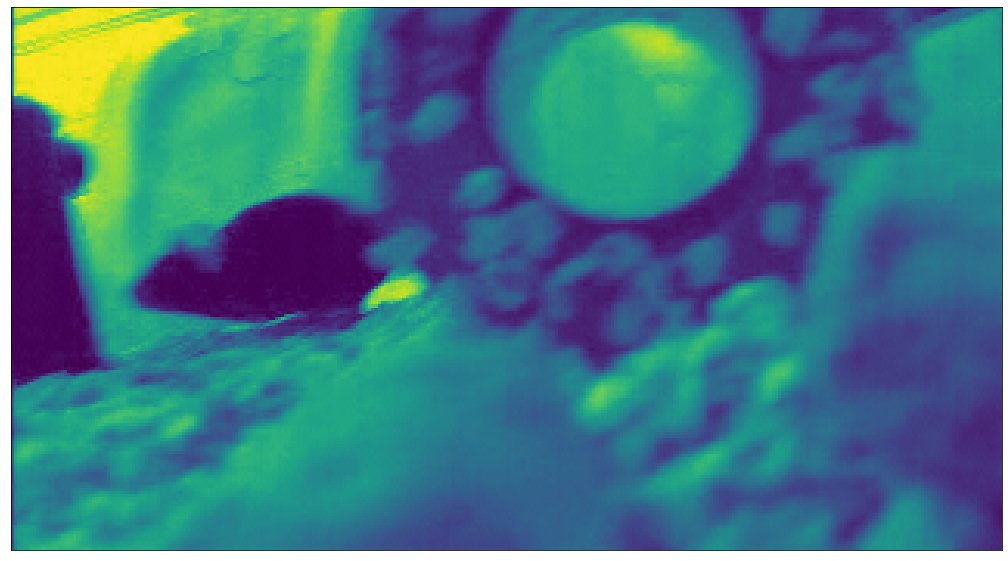

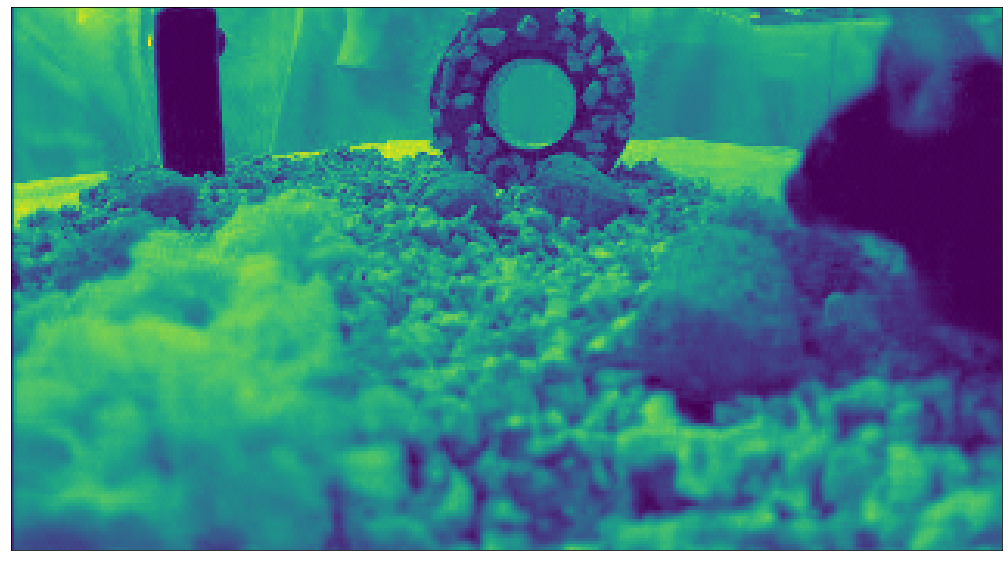

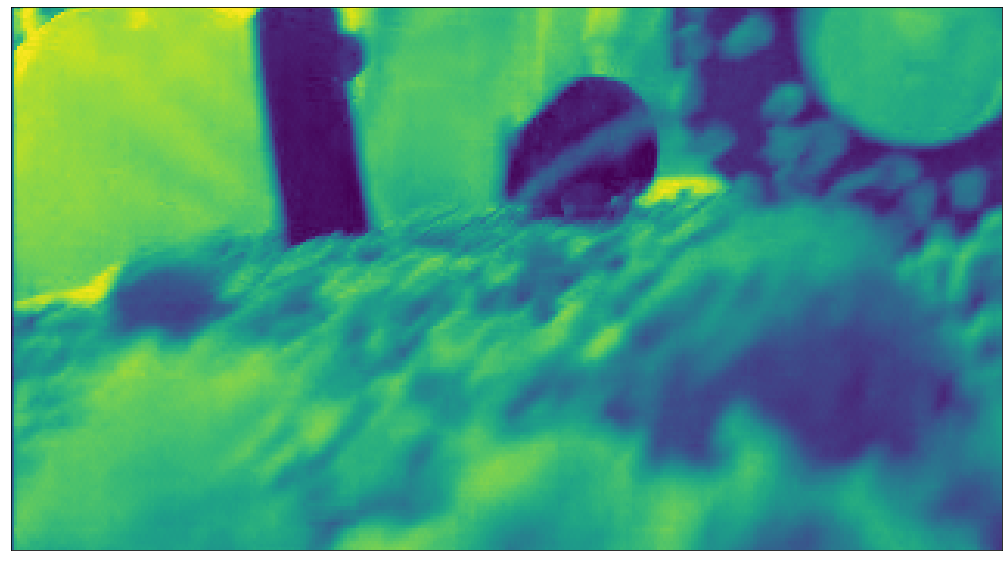

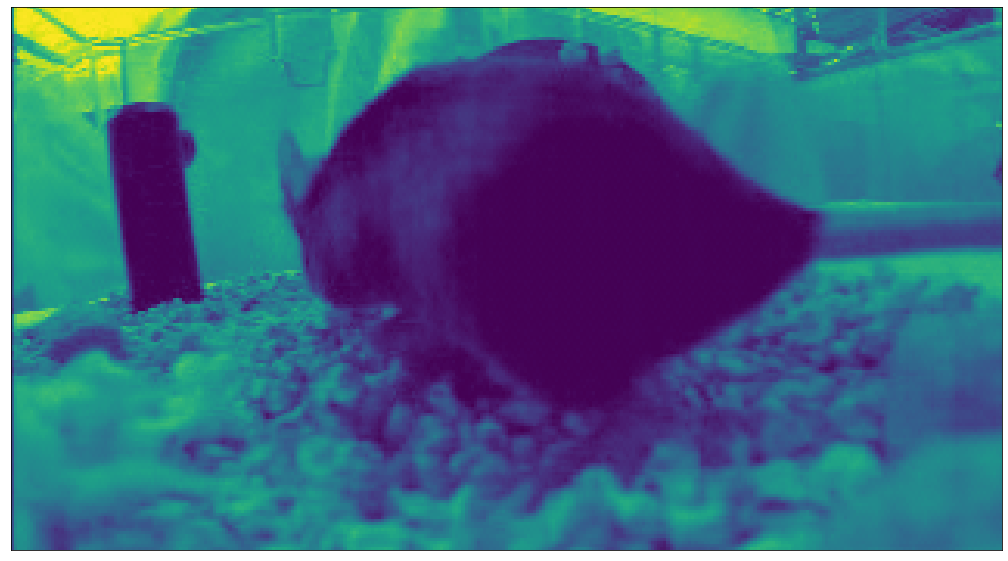

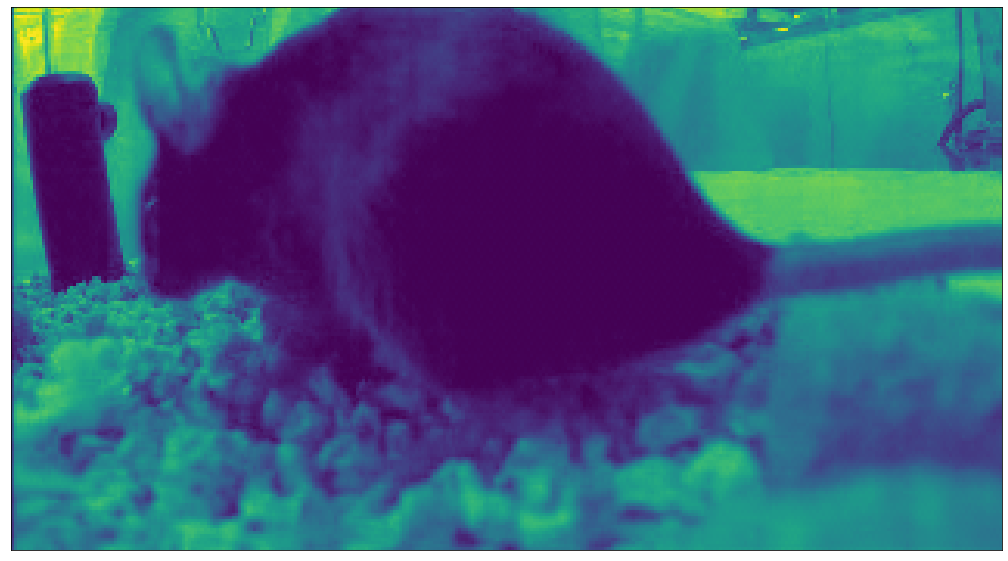

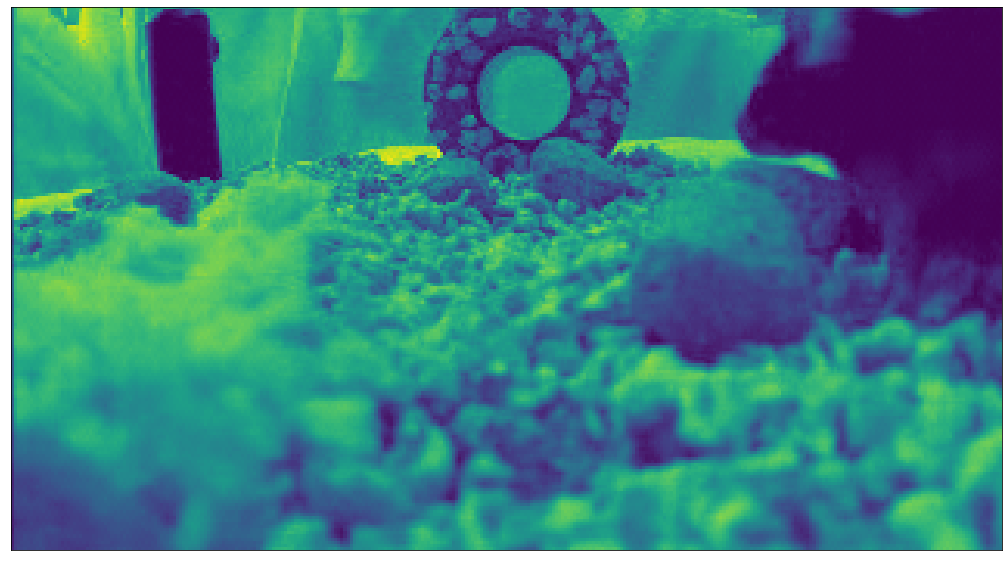

In [46]:
print(f"PIC WITHOUT BOXES")
for pic in pics_without_boxes:
    show([pic])